# The aim of this project is to make stock price prediction using stock price data from yahoo finance

In [2]:
import yfinance as yf

# Download Apple stock data (2010-2023)
data = yf.download('AAPL', start='2011-01-01', end='2024-12-31')
data = data[['Close']]  # Focus on closing prices

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [31]:
#Display the head of the dataframe to check the data
print(data.head())
# Saving the Apple stock closing prices data to a CSV file.
data.to_csv('apple_stock_data.csv', index=True)

print('CSV file has been created.')

Price           Close MA20 MA50 RSI       Lag1       Lag2
Ticker           AAPL                                    
Date                                                     
2011-01-03   9.917945  NaN  NaN NaN        NaN        NaN
2011-01-04   9.969707  NaN  NaN NaN   9.917945        NaN
2011-01-05  10.051262  NaN  NaN NaN   9.969707   9.917945
2011-01-06  10.043139  NaN  NaN NaN  10.051262   9.969707
2011-01-07  10.115058  NaN  NaN NaN  10.043139  10.051262
CSV file has been created.


In [3]:
data.isnull().sum()  # Check for missing values
data.fillna(method='ffill', inplace=True)  # Forward-fill gaps
#ignore warnnings
import warnings
warnings.filterwarnings('ignore')


C:\Users\JOSHUA\AppData\Local\Temp\ipykernel_10040\3298289162.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward-fill gaps


In [4]:
#Normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
#Split data into input (X) and output (y) sequences.
import numpy as np

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60  # Using 60 days of data to predict the next day
X, y = create_sequences(scaled_data, window_size)

In [6]:
#Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
#Adding moving averages, RSI, and MACD:
# Calculate 20-day and 50-day moving averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Calculate RSI (Relative Strength Index)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))



In [8]:
#including past values a predictors
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)

In [9]:
#model building (LSTM MODEL:TENSORFLOW)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0084
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.6187e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.3025e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.2526e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.6688e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.1073e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.2905e-04
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4.8256e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.8861e-04
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.4742e-04
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.4357e-04
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.1177e-04
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.6311e-04
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.5692e-04
Epoch 15/50
87/87 ━

In [10]:
#ARIMA model(baseline)
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(p, d, q)
arima_model = ARIMA(data['Close'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)

C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\JOSHUA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
#Model evaliuation (predicitons and inverse scaling)
# LSTM predictions
lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# ARIMA predictions (already in original scale)
arima_pred = arima_pred.values

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [12]:
#Calculating metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LSTM
lstm_mse = mean_squared_error(y_test_actual, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)

# ARIMA
arima_mse = mean_squared_error(y_test_actual, arima_pred)
arima_rmse = np.sqrt(arima_mse)

print(f"LSTM RMSE: {lstm_rmse}")
print(f"ARIMA RMSE: {arima_rmse}")

LSTM RMSE: 8.541527064031872
ARIMA RMSE: 21.54638783015753


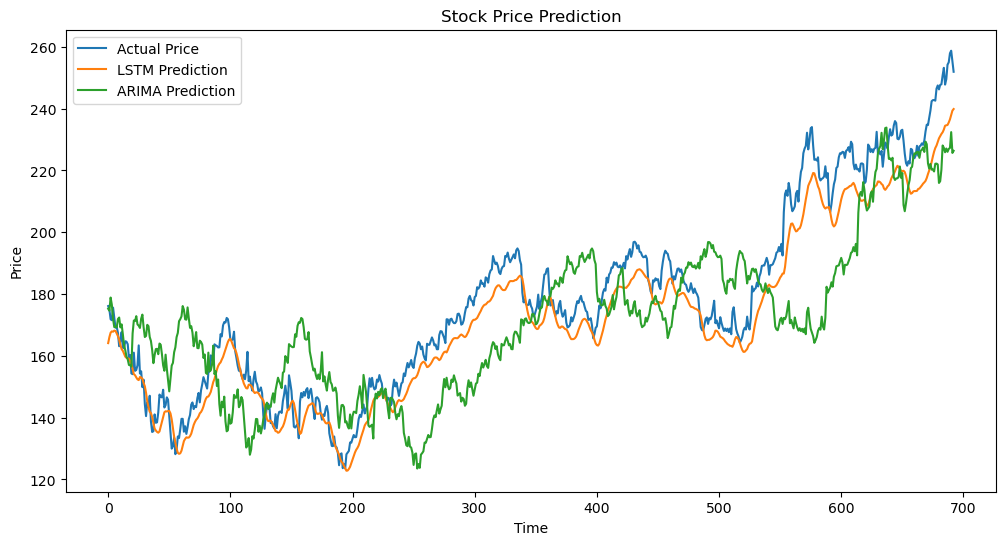

In [13]:
#Visualing Resulta
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
#deployment
# Example using Streamlit
import streamlit as st

st.title('Stock Price Predictor')
ticker = st.text_input('Enter Stock Ticker (e.g., AAPL)', 'AAPL')

if st.button('Predict'):
    data = yf.download(ticker, start='2010-01-01', end='2023-12-31')
    # Preprocess data and generate predictions
    st.line_chart(data['Close'])

2025-02-18 15:58:53.980 
  command:

    streamlit run C:\Users\JOSHUA\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [33]:
from tensorflow.keras.models import load_model

# Assuming your model is named 'model'
model.save('lstm.h5')  # Saves the entire model

In [35]:
import pickle

# Assuming your fitted model is named 'arima_fit'
with open('arima.pkl', 'wb') as f:
    pickle.dump(arima_fit, f)  # Saves the ARIMA model